In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

We use the same dataset as earlier, the top 500 run scoreres in ODI cricket

In [2]:
data = pd.read_csv("/content/ODI data.csv")
print(data.shape)
data

(500, 15)


,Unnamed: 0,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Unnamed: 13
0,0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20,NaN
1,1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15,NaN
2,2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20,NaN
3,3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34,NaN
4,4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,45,PA Wallace (WI),1991-2000,33,33,0,701,103,21.24,1151,60.90,1,2,4,NaN
496,46,SM Ervine (ZIM),2001-2004,42,34,7,698,100,25.85,816,85.53,1,2,5,NaN
497,47,PL Symcox (SA),1993-1999,80,54,13,694,61,16.92,830,83.61,0,3,6,NaN
498,48,Rameez Shahzad (UAE),2016-2018,15,15,2,691,121*,53.15,817,84.57,2,4,1,NaN


In [3]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]# removing outliers in data

<ipython-input-3-e13031db987b>:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]# removing outliers in data


In [4]:
def get_corr_coef(data, col):
  for i in data.columns:
    if(i != col):
      r = np.corrcoef(data[col], data[i])
      print("The correlation coefficient of {} and {} is {}".format(col, i, r[1][0]))

After obtaining the heatmap, we were able to see that the attributes BF, 100, Inns and 50 are highly correlated with our target that is runs

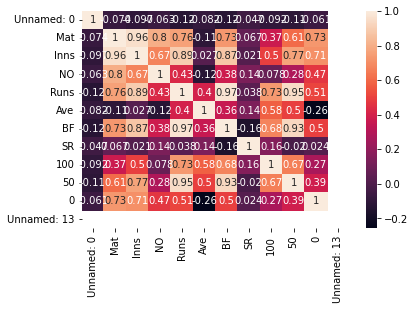

In [5]:
c = data.corr()
sns.heatmap(c, annot = True)

In [6]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
x = data[['Mat', 'Inns', 'NO', 'Ave', 'BF', 'SR', '100', '50']]
y = data[['Runs']]

x_const = sm.add_constant(x)
model = sm.OLS(y, x_const) 
results = model.fit() 

print('The condition number is ',results.condition_number)
p_df=pd.DataFrame({'coef': results.params , 'pvalue': round(results.pvalues,3)})
print("The attributes with pvalue less than 0.05 are as follows")
p_df[ p_df['pvalue']<0.05 ]


The condition number is  37529.850243661334
The attributes with pvalue less than 0.05 are as follows


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,coef,pvalue
const,-917.726768,0.00
Mat,-4.819644,0.00
Inns,15.357596,0.00
NO,3.208072,0.01
Ave,8.128925,0.00
BF,0.249601,0.00
SR,8.569284,0.00
100,70.149887,0.00
50,37.113988,0.00


There exists multicollinearaity as the condition no. is high and the attributes Mat, Inns, NO, Ave, BF, SR, 100 and 50 have p value less than 0.05

**First Model**

In [7]:
df1 = data[data.iloc[:,0]<=45]  
df2 = data[data.iloc[:,0]>45]  

x = data[['Mat', 'Inns', 'NO', 'Ave', 'BF', 'SR', '100', '50']]
y = data['Runs']

x_train = df1[['Mat', 'Inns', 'NO', 'Ave', 'BF', 'SR', '100', '50']]
y_train = df1['Runs']
x_test = df2[['Mat', 'Inns', 'NO', 'Ave', 'BF', 'SR', '100', '50']]
y_test = df2['Runs']

print('shape of df1 = ',df1.shape)
print('shape of df2 = ',df2.shape)

shape of df1 =  (374, 15)
shape of df2 =  (35, 15)


In [8]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()  
lr.fit(x_train, y_train)

print("Intercept: ", lr.intercept_)
print("Coefficients:")
print(list(zip(x, lr.coef_)))

y_pred_lr= lr.predict(x_test)

Intercept:  -913.9194845312832
Coefficients:
[('Mat', -4.56998242760086), ('Inns', 15.191214376342932), ('NO', 3.115383562222389), ('Ave', 8.600973524406257), ('BF', 0.2474408429144983), ('SR', 8.37218100677353), ('100', 70.81668592840758), ('50', 36.803316352383284)]


In [9]:
lr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_lr})
lr_diff.head()

,Actual value,Predicted value
97,4483,4399.120829
98,4440,4314.801647
99,4413,4526.865408
146,3170,3151.133814
147,3143,3115.074757


In [10]:
from sklearn import metrics
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_lr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_lr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr))
print('R squared: ',lr.score(x,y)*100)
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

R squared:  99.39424667074343
Mean Absolute Error: 80.8404404717178
Mean Square Error: 11195.938771354859
Root Mean Square Error: 105.81086320106674


In [11]:
get_corr_coef(data= x_train, col='Inns')

The correlation coefficient of Inns and Mat is 0.9627632304182915
The correlation coefficient of Inns and NO is 0.6794758446381413
The correlation coefficient of Inns and Ave is 0.05675743476008996
The correlation coefficient of Inns and BF is 0.8794940530064446
The correlation coefficient of Inns and SR is 0.03139124710720164
The correlation coefficient of Inns and 100 is 0.5110367138760545
The correlation coefficient of Inns and 50 is 0.7792982572146281


Inns is highly correlated with NO Mat BF 50 with correlation coefficient more than 0.65

In [12]:
get_corr_coef(data= x_train, col='100')

The correlation coefficient of 100 and Mat is 0.3969877434993752
The correlation coefficient of 100 and Inns is 0.5110367138760544
The correlation coefficient of 100 and NO is 0.10634502421556982
The correlation coefficient of 100 and Ave is 0.5936373556774897
The correlation coefficient of 100 and BF is 0.6826378708339351
The correlation coefficient of 100 and SR is 0.1552915519338056
The correlation coefficient of 100 and 50 is 0.6720988543882299


100 is highly correlated with BF 50 

**Second Model**

In [13]:
x_train_1 = df1[['Inns', 'BF', '100', '50']]
y_train_1 = df1['Runs']
x_test_1 = df2[['Inns', 'BF', '100', '50']]
y_test_1 = df2['Runs']
x_1 = data[['Inns', 'BF', '100', '50']]
y_1 = data[['Runs']]

In [14]:
X2_train_1 = sm.add_constant(x_train_1)
est_train_1 = sm.OLS(y_train_1, X2_train_1)
est2_1 = est_train_1.fit()
print(est2_1.summary())

                            OLS Regression Results                            
Dep. Variable:                   Runs   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     8588.
Date:                Sun, 25 Dec 2022   Prob (F-statistic):               0.00
Time:                        15:00:47   Log-Likelihood:                -2405.4
No. Observations:                 374   AIC:                             4821.
Df Residuals:                     369   BIC:                             4840.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -39.2935     15.741     -2.496      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [15]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
# If p-value < 0.05 -->Significant
# If p-value > 0.05 -->Not Significant

x_const = sm.add_constant(x_1)
model = sm.OLS(y_1, x_const) 
results = model.fit() 

print('The condition number is ',results.condition_number)
p_df=pd.DataFrame({'coef': results.params , 'pvalue': round(results.pvalues,3)})
print("The attributes with pvalue less than 0.05 are as follows")
p_df[ p_df['pvalue']<0.05 ]
     

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


The condition number is  6929.318975530079
The attributes with pvalue less than 0.05 are as follows


,coef,pvalue
const,-37.413560,0.015
Inns,10.251909,0.000
BF,0.144480,0.000
100,106.406162,0.000
50,57.298460,0.000


In [16]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()  
lr.fit(x_train_1, y_train_1)

LinearRegression()

In [17]:
print("Intercept: ", lr.intercept_)
print("Coefficients:")
print(list(zip(x_1, lr.coef_)))

#Prediction of test set
y_pred_lr_1= lr.predict(x_test_1)

Intercept:  -39.29345047191373
Coefficients:
[('Inns', 10.598936914967902), ('BF', 0.13962584254009297), ('100', 107.30479773322874), ('50', 56.54786754865236)]


In [18]:
lr_diff_1 = pd.DataFrame({'Actual value': y_test_1, 'Predicted value': y_pred_lr_1})
lr_diff_1.head()

,Actual value,Predicted value
97,4483,4467.882756
98,4440,4381.014853
99,4413,4700.371911
146,3170,3155.838346
147,3143,3094.546624


In [19]:
from sklearn import metrics
meanAbErr = metrics.mean_absolute_error(y_test_1, y_pred_lr_1)
meanSqErr = metrics.mean_squared_error(y_test_1, y_pred_lr_1)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test_1, y_pred_lr_1))
print('R squared: {:.2f}'.format(lr.score(x_1,y_1)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

R squared: 98.86
Mean Absolute Error: 116.76388673080568
Mean Square Error: 32304.829230933392
Root Mean Square Error: 179.7354423338185


The variables Inns, BF, 100, 50 have a P-Value less than 0.05

The R-squared value for the model with all the variables was 99.39

Inns was correlated with all the variables barring Ave

Now in a model with only Inns, BF, 100 and 50 is trained.

The coeffcient of 100 in this model was 106.4

In the previous model the coefficient of 100 was 70

So the coefficient has increased in this model which says that 100 has a greater influence on this model than the previous one.

b. The R-sqaured value of the new model is 98.86 which has been decreased from the previous model which was 99.37. So the first model is a better model for our varibles than our previous models.